In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Carga de datos

In [2]:
# Se carga el dataset
hoteles = pd.read_csv("hoteles-entrena.csv")

#Se convierte arrival_date a tipo datetime
hoteles['arrival_date'] = pd.to_datetime(hoteles['arrival_date'])

#Se extrae el mes y el día de arrival_date
hoteles['arrival_month'] = hoteles['arrival_date'].dt.month_name()

hoteles.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date,arrival_month
0,Resort_Hotel,342,0,0,2,none,BB,PRT,Direct,Direct,0,0,0,C,C,3,No_Deposit,NaN,NaN,0,Transient,0.0,none,0,2015-07-01,July
1,Resort_Hotel,737,0,0,2,none,BB,PRT,Direct,Direct,0,0,0,C,C,4,No_Deposit,NaN,NaN,0,Transient,0.0,none,0,2015-07-01,July
2,Resort_Hotel,7,0,1,1,none,BB,GBR,Direct,Direct,0,0,0,A,C,0,No_Deposit,NaN,NaN,0,Transient,75.0,none,0,2015-07-01,July
3,Resort_Hotel,13,0,1,1,none,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No_Deposit,304.0,NaN,0,Transient,75.0,none,0,2015-07-01,July
4,Resort_Hotel,14,0,2,2,none,BB,GBR,Online_TA,TA/TO,0,0,0,A,A,0,No_Deposit,240.0,NaN,0,Transient,98.0,none,1,2015-07-01,July


## Receta

In [3]:
cols_to_drop = ['assigned_room_type',
                'deposit_type',
                'arrival_date',
                'meal',
                'distribution_channel',
                'customer_type',
                'company',
                'days_in_waiting_list', 'country']

#Se descartan columnas que no funcionan
hoteles.drop(columns=cols_to_drop, inplace=True)
hoteles.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,agent,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_month
0,Resort_Hotel,342,0,0,2,none,Direct,0,0,0,C,3,NaN,0.0,none,0,July
1,Resort_Hotel,737,0,0,2,none,Direct,0,0,0,C,4,NaN,0.0,none,0,July
2,Resort_Hotel,7,0,1,1,none,Direct,0,0,0,A,0,NaN,75.0,none,0,July
3,Resort_Hotel,13,0,1,1,none,Corporate,0,0,0,A,0,304.0,75.0,none,0,July
4,Resort_Hotel,14,0,2,2,none,Online_TA,0,0,0,A,0,240.0,98.0,none,1,July


In [4]:
# agent
hoteles.loc[~hoteles['agent'].isin([240, 9]), 'agent'] = 0

# arrival_month
hoteles.loc[~hoteles['arrival_month'].isin(['July', 'August']), 'arrival_month'] = 'Other'

# reserved_room_type
hoteles.loc[~hoteles['reserved_room_type'].isin(['F', 'G']), 'reserved_room_type'] = 'Other'

# market_segment
hoteles.loc[~hoteles['market_segment'].isin(['Online_TA', 'Offline_TA/TO', 'Direct']), 'market_segment'] = 'Other'

## Formato de datos

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder

In [6]:
target = 'children'

#Categorical features
cat_feats = ['hotel', 'adults', 'market_segment', 'is_repeated_guest', 'reserved_room_type',
             'agent','arrival_month', 'required_car_parking_spaces']

#Objeto de transformación de columnas
column_selector = ColumnTransformer([
    ('label_bin2', OneHotEncoder(sparse=False), cat_feats),
    ("scaler", MinMaxScaler(), make_column_selector(dtype_include=['int', 'float']))
])

In [7]:
X = column_selector.fit_transform(hoteles)
X.shape

(61969, 35)

In [8]:
Y_encoded = LabelEncoder().fit_transform(hoteles[target])
Y_encoded.shape

(61969,)

**IMPORTANTE**: 

La salida del encoder es:
* Valor $0\rightarrow$ `children`
* Valor $1\rightarrow$ `none`

## Partición del dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y_encoded, test_size=0.2)
xtrain.shape, xtest.shape

((49575, 35), (12394, 35))

In [11]:
ytrain.shape, ytest.shape

((49575,), (12394,))

# Feed-Forward ANN

## Arquitectura de red

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adagrad
from tensorflow.keras.regularizers import l2

In [20]:
def define_model():
    #Arquitectura de red
    model = Sequential()
    
    #Capa de entrada con dropout
    model.add(Dense(35, input_shape=(35,), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    
    #Capa intermendia con dropout
    model.add(Dense(35, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    
    #Capa de salida
    model.add(Dense(1, activation='sigmoid'))
    
    #Optimizador
    opt = Adagrad(learning_rate=0.01)
    
    #Compilando modelo
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

## Evaluando sobreajuste

Epochs: 150

In [21]:
#Iniciar instancia de modelo
modelo = define_model()

#Almacenar información histórica
history = modelo.fit(x=xtrain, y=ytrain, batch_size=30, epochs=100, verbose=1, validation_data=(xtest, ytest))

Epoch 1/100
1653/1653 [==============================] - 3s 1ms/step - loss: 0.5746 - accuracy: 0.9256 - val_loss: 0.3599 - val_accuracy: 0.9208
Epoch 2/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2997 - accuracy: 0.9265 - val_loss: 0.2704 - val_accuracy: 0.9208
Epoch 3/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2560 - accuracy: 0.9265 - val_loss: 0.2529 - val_accuracy: 0.9208
Epoch 4/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2462 - accuracy: 0.9265 - val_loss: 0.2481 - val_accuracy: 0.9208
Epoch 5/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2419 - accuracy: 0.9266 - val_loss: 0.2444 - val_accuracy: 0.9208
Epoch 6/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2391 - accuracy: 0.9270 - val_loss: 0.2426 - val_accuracy: 0.9208
Epoch 7/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2380 - accuracy: 0.9272 - val_loss: 0.2409 - val_ac

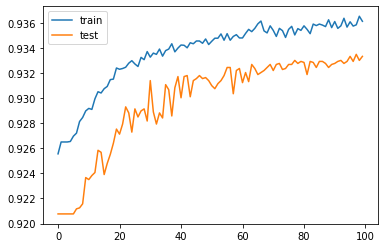

In [22]:
#Resumir la historia de los accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Validación cruzada

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from scikeras.wrappers import KerasClassifier

In [17]:
estimator = KerasClassifier(model=define_model, batch_size=30, epochs=100, verbose=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [17]:
%%time
results = cross_validate(estimator, xtrain, ytrain, scoring='neg_log_loss', cv=kfold, n_jobs=-1)

Epoch 1/100
1322/1322 [==============================] - 3s 2ms/step - loss: 0.1946 - accuracy: 0.9366
Epoch 2/100
1322/1322 [==============================] - 2s 2ms/step - loss: 0.1744 - accuracy: 0.9434
Epoch 3/100
1322/1322 [==============================] - 2s 2ms/step - loss: 0.1686 - accuracy: 0.9451
Epoch 4/100
1322/1322 [==============================] - 2s 2ms/step - loss: 0.1660 - accuracy: 0.9467
Epoch 5/100
1322/1322 [==============================] - 2s 1ms/step - loss: 0.1628 - accuracy: 0.9467
Epoch 6/100
1322/1322 [==============================] - 1s 1ms/step - loss: 0.1606 - accuracy: 0.9482
Epoch 7/100
1322/1322 [==============================] - 2s 1ms/step - loss: 0.1594 - accuracy: 0.9482
Epoch 8/100
1322/1322 [==============================] - 2s 2ms/step - loss: 0.1566 - accuracy: 0.9492
Epoch 9/100
1322/1322 [==============================] - 2s 2ms/step - loss: 0.1541 - accuracy: 0.9495
Epoch 10/100
1322/1322 [==============================] - 2s 2ms/step - l

In [18]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 94.98% (0.20%)


Con los datos de **entrenamiento** se ve un resultado aceptable, recordando que la métrica utilizada es `accuracy`.

Sin embargo, las redes neuronales son susceptibles a sobreajuste.

## Entrenamiento y Evaluación

In [16]:
%%time
estimator.fit(xtrain, ytrain)

Epoch 1/100
1653/1653 [==============================] - 3s 1ms/step - loss: 0.5409 - accuracy: 0.9260
Epoch 2/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2520 - accuracy: 0.9337
Epoch 3/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.2071 - accuracy: 0.9383
Epoch 4/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.1961 - accuracy: 0.9407
Epoch 5/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.1916 - accuracy: 0.9420
Epoch 6/100
1653/1653 [==============================] - 3s 2ms/step - loss: 0.1878 - accuracy: 0.9426
Epoch 7/100
1653/1653 [==============================] - 3s 2ms/step - loss: 0.1855 - accuracy: 0.9436
Epoch 8/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.1838 - accuracy: 0.9441
Epoch 9/100
1653/1653 [==============================] - 2s 1ms/step - loss: 0.1820 - accuracy: 0.9445
Epoch 10/100
1653/1653 [==============================] - 3s 2ms/step - l

KerasClassifier(
	model=<function define_model at 0x000002ADC404FA60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=30
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

**Predicciones** en el conjunto de prueba

In [17]:
from sklearn.metrics import log_loss

In [18]:
estimator.predict_proba(xtest)

414/414 [==============================] - 0s 946us/step


array([[6.5461397e-03, 9.9345386e-01],
       [1.7465353e-02, 9.8253465e-01],
       [1.8703341e-03, 9.9812967e-01],
       ...,
       [6.5213442e-04, 9.9934787e-01],
       [1.2292862e-03, 9.9877071e-01],
       [8.4346533e-03, 9.9156535e-01]], dtype=float32)

In [19]:
log_loss(y_true=ytest, y_pred=estimator.predict_proba(xtest))

414/414 [==============================] - 0s 929us/step


0.15460597977449084

# Predicción con datos reales

## Tratamiento de datos reales

**Primero** se concatenan los datos de entrenamiento y los datos de prueba en un dataset único.

In [40]:
# Se carga el dataset
hoteles_prueba = pd.read_csv("hoteles-prueba.csv", index_col='id')
hoteles_prueba['arrival_date'] = pd.to_datetime(hoteles_prueba['arrival_date'])
hoteles_prueba['arrival_month'] = hoteles_prueba['arrival_date'].dt.month_name()
hoteles_prueba['arrival_day'] = hoteles_prueba['arrival_date'].dt.day_name()

#Columnas por descartar
hoteles_prueba.drop(columns=cols_to_drop, inplace=True)

hoteles_prueba

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_month,arrival_day
id,,,,,,,,,,,,,,,,,,,,
1,Resort_Hotel,3,1,0,1,SC,Corporate,Corporate,0,0,0,A,I,0,Transient,0.00,none,0,May,Monday
2,Resort_Hotel,3,0,1,1,BB,Corporate,Corporate,0,0,0,A,A,0,Transient,135.00,none,0,August,Thursday
3,Resort_Hotel,4,0,1,1,BB,Corporate,Corporate,0,0,2,A,D,0,Transient,135.00,none,0,August,Tuesday
4,Resort_Hotel,4,0,1,1,BB,Corporate,Corporate,0,0,3,A,A,1,Transient,142.00,parking,0,July,Tuesday
5,Resort_Hotel,186,4,6,3,HB,Direct,Direct,0,0,1,E,E,0,Transient,248.10,parking,1,July,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,City_Hotel,23,2,5,2,BB,Offline_TA/TO,TA/TO,0,0,0,A,A,0,Transient,96.14,none,0,August,Wednesday
13194,City_Hotel,102,2,5,3,BB,Online_TA,TA/TO,0,0,0,E,E,0,Transient,225.43,none,2,August,Thursday
13195,City_Hotel,34,2,5,2,BB,Online_TA,TA/TO,0,0,0,D,D,0,Transient,157.71,none,4,August,Thursday


In [41]:
#Alamcenamos el número de filas datos entrenamiento para descatarlas despues
filas_entrena = hoteles.shape[0] - 1
filas_entrena

61968

In [35]:
#Concatenamos entrena y prueba para garantizar el mismo número de columnas finales
stacked_df = hoteles.drop('children', axis=1)
stacked_df = pd.concat((stacked_df, hoteles_prueba), ignore_index=True)

stacked_df

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_month,arrival_day
0,Resort_Hotel,342,0,0,2,BB,Direct,Direct,0,0,0,C,C,3,Transient,0.00,none,0,July,Wednesday
1,Resort_Hotel,737,0,0,2,BB,Direct,Direct,0,0,0,C,C,4,Transient,0.00,none,0,July,Wednesday
2,Resort_Hotel,7,0,1,1,BB,Direct,Direct,0,0,0,A,C,0,Transient,75.00,none,0,July,Wednesday
3,Resort_Hotel,13,0,1,1,BB,Corporate,Corporate,0,0,0,A,A,0,Transient,75.00,none,0,July,Wednesday
4,Resort_Hotel,14,0,2,2,BB,Online_TA,TA/TO,0,0,0,A,A,0,Transient,98.00,none,1,July,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75161,City_Hotel,23,2,5,2,BB,Offline_TA/TO,TA/TO,0,0,0,A,A,0,Transient,96.14,none,0,August,Wednesday
75162,City_Hotel,102,2,5,3,BB,Online_TA,TA/TO,0,0,0,E,E,0,Transient,225.43,none,2,August,Thursday
75163,City_Hotel,34,2,5,2,BB,Online_TA,TA/TO,0,0,0,D,D,0,Transient,157.71,none,4,August,Thursday
75164,City_Hotel,109,2,5,2,BB,Online_TA,TA/TO,0,0,0,A,A,0,Transient,104.40,none,0,August,Thursday


**Después** se hace la transformación de datos

In [36]:
X_real = column_selector.fit_transform(stacked_df)
X_real.shape

(75166, 73)

**Finalmente** se descartan los datos del conjunto de entrenamiento

In [43]:
X_real = X_real[filas_entrena:-1:1]
X_real.shape

(13197, 73)

**Predicciones**

In [44]:
y_pred = estimator.predict_proba(X_real)
y_pred

440/440 [==============================] - 0s 911us/step


array([[0.18834913, 0.8116509 ],
       [0.00660074, 0.99339926],
       [0.00755215, 0.99244785],
       ...,
       [0.14472306, 0.85527694],
       [0.30985874, 0.69014126],
       [0.03299665, 0.96700335]], dtype=float32)

In [47]:
hoteles_prueba['prob'] = y_pred[:,0]
hoteles_prueba[['prob']]

,prob
id,
1,0.188349
2,0.006601
3,0.007552
4,0.008963
5,0.010092
...,...
13193,0.164465
13194,0.029895
13195,0.144723


In [48]:
hoteles_prueba[['prob']].to_csv('results_ann.csv')